In [770]:
import pandas as pd
import numpy as np
import seaborn as sns

events_data - данные о действиях, которые совершают студенты со стэпами
step_id - id стэпа
user_id - анонимизированный id юзера
timestamp - время наступления события в формате unix date
action - событие, возможные значения

discovered - пользователь перешел на стэп
viewed - просмотр шага,
started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
passed - удачное решение практического шага

In [771]:
events_data = pd.read_csv('static/First_contest//event_data_train.csv')
events_data['data'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.data.dt.date

In [772]:
events_data.head(10)

,step_id,timestamp,action,user_id,data,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15


In [773]:
submissions_data = pd.read_csv('C:/Users/filip/ML/static/First_contest/submissions_data_train.csv')

submissions_data - данные о времени и статусах сабмитов к практическим заданиям

step_id - id стэпа
timestamp - время отправки решения в формате unix date
submission_status - статус решения
user_id - анонимизированный id юзера

In [774]:
submissions_data['data'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.data.dt.date

In [775]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,data,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


<AxesSubplot: xlabel='day'>

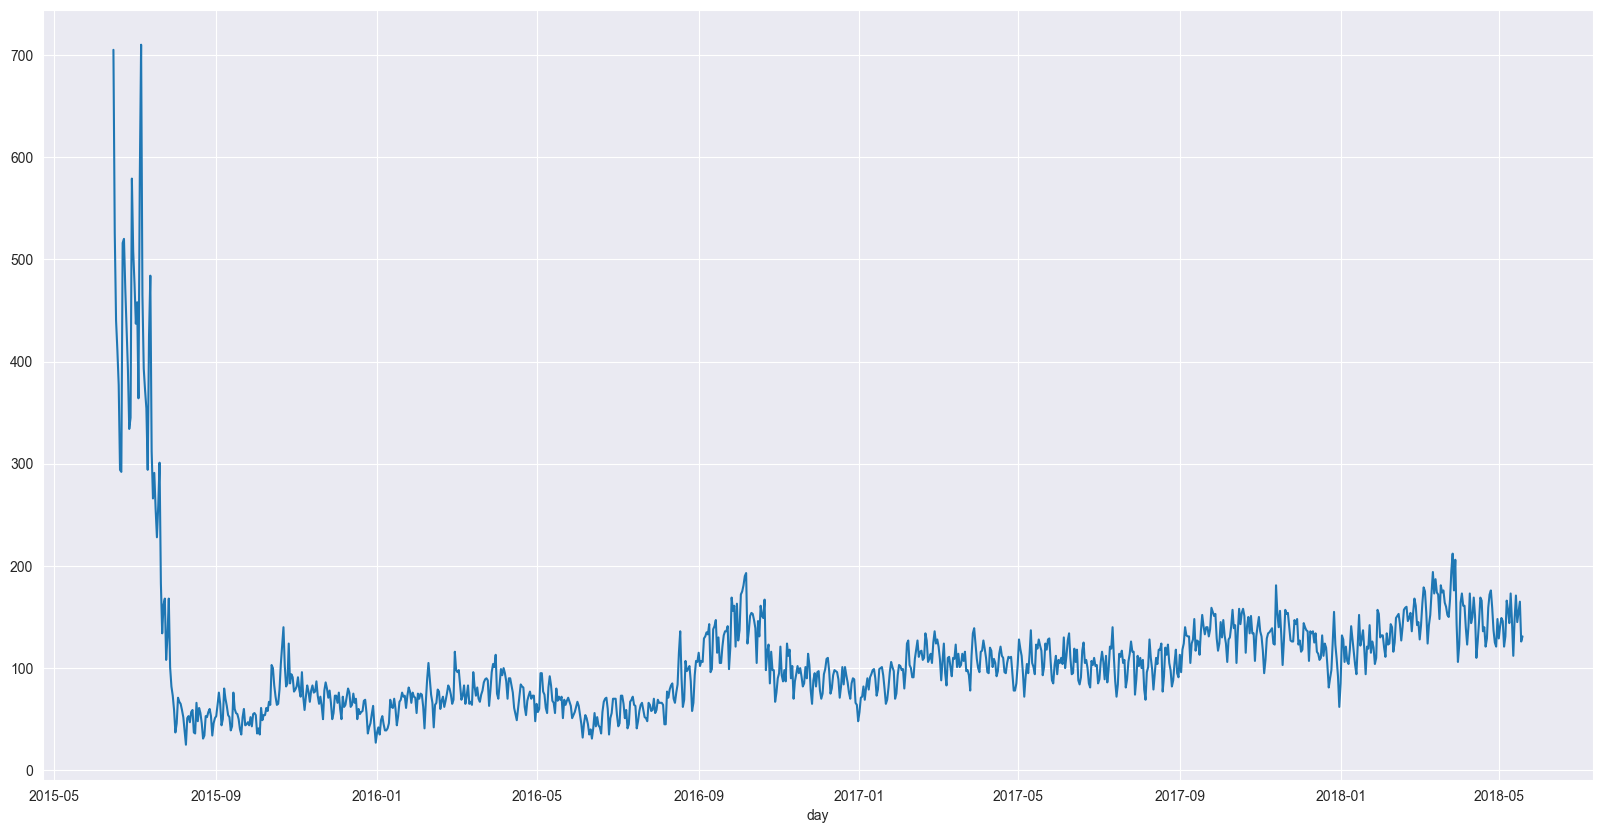

In [776]:
events_data.groupby('day').user_id.nunique().plot(figsize=(20, 10))

<AxesSubplot: >

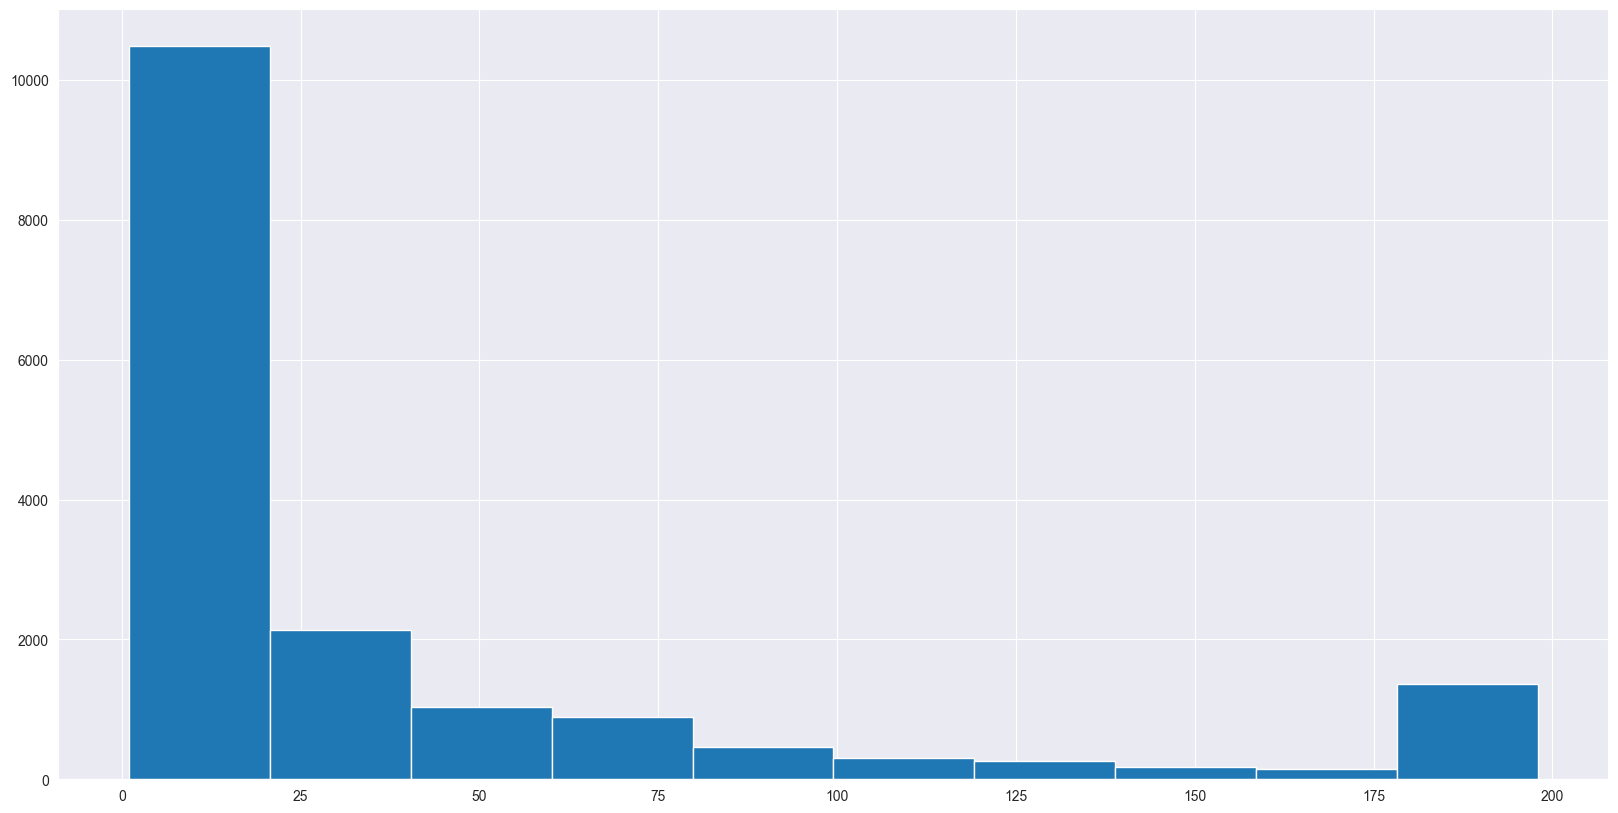

In [777]:
events_data[events_data.action == 'passed'].groupby('user_id', as_index=False) \
    .agg({"step_id": "count"}).rename(columns={'step_id': 'passed_step'}).passed_step.hist(figsize=(20, 10))

В наблюдения не учитываются пользователи с 0 степов

<AxesSubplot: >

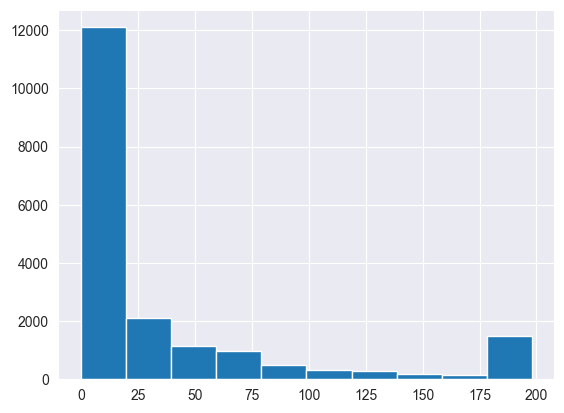

In [778]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()

In [779]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename({'timestamp': 'last_timestamp'}, axis='columns')

In [780]:
now = 1526772811
drop_out_threshold = 2592000

In [781]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_scores = submissions_data.pivot_table(index='user_id', \
                                            columns='submission_status', \
                                            values='step_id', \
                                            aggfunc='count', \
                                            fill_value=0) \
    .reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [782]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [783]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

In [784]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).groupby('user_id')[
    'timestamp'].apply(list).apply(np.diff).values

In [785]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int32

In [786]:
gap_data = gap_data / (24 * 60 * 60)

In [787]:
(24 * 60 * 60 * 30)

2592000

<AxesSubplot: >

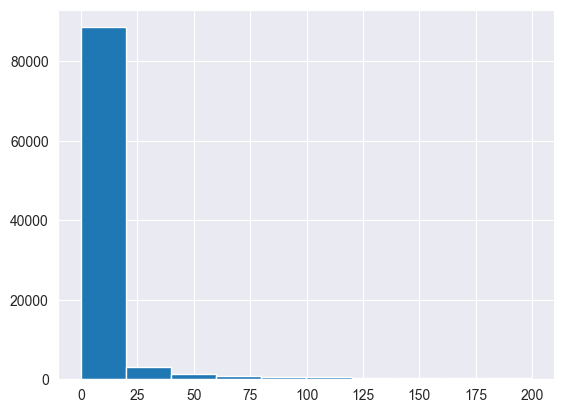

In [788]:
gap_data[gap_data < 200].hist()

In [789]:
gap_data.quantile(0.90)

18.325995370370403

In [790]:
users_invent_data = events_data.pivot_table(index='user_id',
                                            columns='action',
                                            values='step_id',
                                            aggfunc='count',
                                            fill_value=0).reset_index()
users_data = users_data.merge(users_invent_data, how='outer')

In [791]:
users_invent_data = events_data.pivot_table(index='user_id',
                                            columns='action',
                                            values='step_id',
                                            aggfunc='count',
                                            fill_value=0).reset_index()
users_days = events_data.groupby('user_id').day.nunique()
users_days.to_frame().reset_index()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [792]:
users_data = users_data.merge(users_days, on='user_id', how='outer')
users_data['passed_corse'] = users_data.passed > 170
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


In [793]:
submissions_data.step_id.mode()

0    31978
Name: step_id, dtype: int64

In [794]:
events_data.pivot_table(index='user_id', columns='action', values='step_id',
                        aggfunc='count', fill_value=0).reset_index().sort_values('started_attempt')

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
10166,14118,5,5,0,5
10168,14121,1,0,0,1
10170,14123,1,1,0,6
10171,14125,1,1,0,1
...,...,...,...,...,...
1204,1649,194,194,281,807
4825,6662,198,197,285,1054
6062,8394,131,94,337,1070
2611,3572,194,193,550,6968


In [795]:
events_data.tail()

,step_id,timestamp,action,user_id,data,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


array([[<AxesSubplot: title={'center': 'user_id'}>,
        <AxesSubplot: title={'center': 'discovered'}>],
       [<AxesSubplot: title={'center': 'passed'}>,
        <AxesSubplot: title={'center': 'started_attempt'}>],
       [<AxesSubplot: title={'center': 'viewed'}>, <AxesSubplot: >]],
      dtype=object)

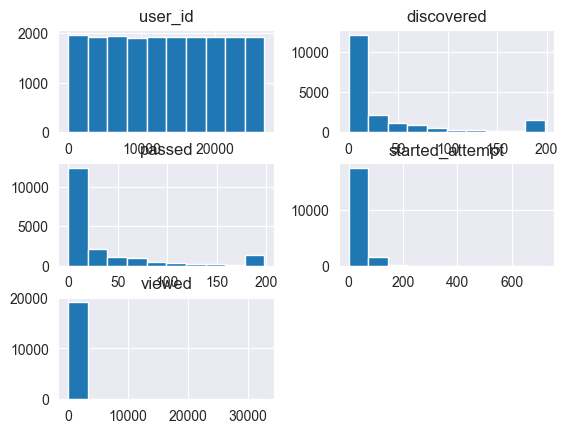

In [796]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().hist()

In [797]:
user_min_time = events_data.groupby('user_id', as_index=False). \
    agg({'timestamp': 'min'}) \
    .rename({"timestamp": 'min_timestamp'}, axis=1)
users_data = users_data.merge(user_min_time, how='outer')

In [798]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [799]:
event_data_train = pd.DataFrame()

events_data['user_time'] = events_data.user_id.map(str) \
                           + "_" + events_data.timestamp.map(str)
events_data

,step_id,timestamp,action,user_id,data,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
...,...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19,11677_1526772685
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750


In [800]:
learning_time_threshold = 3 * 24 * 60 * 60

In [801]:
user_learning_time_threshold = user_min_time.user_id.map(str) \
                               + '_' + (learning_time_threshold + user_min_time.min_timestamp).map(str)
user_min_time["user_learning_time_threshold"] = user_learning_time_threshold
user_min_time

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860
...,...,...,...
19229,26790,1451484016,26790_1451743216
19230,26793,1510225031,26793_1510484231
19231,26794,1495287049,26794_1495546249
19232,26797,1508425316,26797_1508684516


In [802]:
events_data = events_data \
    .merge(user_min_time[['user_id', 'user_learning_time_threshold']],
           how='outer')

In [803]:
events_data.shape

(3480703, 8)

In [804]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [805]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [806]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data.head(20)

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp,correct_y,wrong_y
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464,0.0,0.0
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364,2.0,0.0
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476,29.0,23.0
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809,2.0,2.0
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660,0.0,0.0
5,8,1481466913,True,9.0,21.0,109,84,37,156,2,False,1480603427,9.0,21.0
6,9,1484999497,True,0.0,0.0,3,3,0,4,1,False,1484999434,0.0,0.0
7,11,1526140625,False,0.0,0.0,1,0,1,1,1,False,1526140624,0.0,0.0
8,14,1436368676,True,0.0,1.0,4,3,1,9,1,False,1436366155,0.0,1.0
9,16,1513162585,True,77.0,106.0,196,196,108,651,21,True,1435674765,77.0,106.0


In [807]:
users_events_data = events_data.pivot_table(index='user_id',
                                            columns='action',
                                            values='step_id',
                                            aggfunc='count',
                                            fill_value=0).reset_index()

In [808]:
users_data = users_data.merge(users_events_data, how='outer')

In [809]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp,correct_y,wrong_y
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464,0.0,0.0
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364,2.0,0.0
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476,29.0,23.0
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809,2.0,2.0
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660,0.0,0.0


In [810]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [811]:
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
...,...,...
19229,26790,4
19230,26793,1
19231,26794,9
19232,26797,2


In [812]:
users_data = users_data.merge(users_days, on='user_id', how='outer')

In [813]:
users_data

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,discovered,passed,started_attempt,viewed,day_x,passed_corse,min_timestamp,correct_y,wrong_y,day_y
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464,0.0,0.0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364,2.0,0.0,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476,29.0,23.0,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809,2.0,2.0,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016,1.0,0.0,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031,0.0,0.0,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049,33.0,9.0,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316,2.0,0.0,2


In [814]:
users_data.user_id.nunique()

19234

In [815]:
events_data.user_id.nunique()

19234

In [816]:
users_data['passed_course'] = users_data.passed > 170

In [817]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,discovered,passed,started_attempt,viewed,day_x,passed_corse,min_timestamp,correct_y,wrong_y,day_y
passed_course,,,,,,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [818]:
1425 / 17809

0.08001572238755686

In [819]:
users_data[users_data.passed_course].day.median()

AttributeError: 'DataFrame' object has no attribute 'day'

In [820]:
users_data[users_data.passed_course].day.hist()

AttributeError: 'DataFrame' object has no attribute 'day'

In [821]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [822]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [823]:
users_data = users_data.merge(user_min_time, how='outer')

In [824]:
users_data

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,discovered,passed,started_attempt,viewed,day_x,passed_corse,min_timestamp,correct_y,wrong_y,day_y,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464,0.0,0.0,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364,2.0,0.0,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476,29.0,23.0,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809,2.0,2.0,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660,0.0,0.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016,1.0,0.0,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031,0.0,0.0,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049,33.0,9.0,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316,2.0,0.0,2,False


In [825]:
events_data.head()

,step_id,timestamp,action,user_id,data,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Находим количество действий пользователя в ближайшие 3 дня

In [826]:
# for user_id in users_data.user_id:
#     min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
#     time_to_threshold = min_user_time * 3 * 24 * 60 * 60
#
#     users_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_to_treshold)]
#     break

In [827]:
events_data

,step_id,timestamp,action,user_id,data,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [828]:
events_data['user_time'] = events_data.user_id.map(str) \
                           + "_" + events_data.timestamp.map(str)

In [829]:
events_data

,step_id,timestamp,action,user_id,data,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [830]:
learning_time_to_threshold = 3 * 24 * 60 * 60
learning_time_to_threshold

259200

In [831]:
user_learning_time_threshold = user_min_time.user_id.map(str) \
                               + '_' + (learning_time_to_threshold + user_min_time.min_timestamp).map(str)
user_learning_time_threshold

0            1_1473086664
1            2_1514642564
2            3_1434617676
3            5_1466416009
4            7_1521893860
               ...       
19229    26790_1451743216
19230    26793_1510484231
19231    26794_1495546249
19232    26797_1508684516
19233    26798_1521234963
Length: 19234, dtype: object

In [832]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [833]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [834]:
events_data.shape

(3480703, 8)

In [835]:
events_data

,step_id,timestamp,action,user_id,data,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [836]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [837]:
events_data_train

,step_id,timestamp,action,user_id,data,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [838]:
submissions_data.mode()

,step_id,timestamp,submission_status,user_id,data,day
0,31978,1491590313,wrong,12265,2017-04-07 18:38:33,2015-07-06


In [839]:
events_data_train.groupby('user_id').day.nunique().max()

4

In [840]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [841]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day': 'days'})

In [842]:
X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


In [843]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(
    columns={'step_id': 'steps_tried'})

In [844]:
X = X.merge(steps_tried, on='user_id', how='outer')

In [845]:
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


In [846]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                                               columns='submission_status',
                                               values='step_id',
                                               aggfunc='count',
                                               fill_value=0).reset_index(), how='outer')

In [847]:
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [848]:
X['correct_ration'] = X.correct / (X.correct + X.wrong)

In [849]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                                          columns='action', \
                                          values='step_id', \
                                          aggfunc='count', \
                                          fill_value=0) \
            .reset_index()[['user_id', 'viewed']], how='outer')

In [850]:
X = X.fillna(0)

In [851]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [852]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [853]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

y = X.passed_course.map(int)

X = X.drop(['passed_course', 'is_gone_user'], axis=1)

X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [854]:
print(len(X))
print(len(y))
X

17985
17985


,days,steps_tried,correct,wrong,correct_ration,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


In [863]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [856]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3, 6), 'max_leaf_nodes': range(6, 15), 'min_samples_leaf': range(1, 4),
              'min_samples_split': range(2, 5)}
grid_search_cv_clf = GridSearchCV(dt, parameters, cv=4)
grid_search_cv_clf.fit(X_train, y_train)
model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model, X_train, y_train, cv=4).mean())

{'max_depth': 5, 'max_leaf_nodes': 11, 'min_samples_leaf': 2, 'min_samples_split': 2} 0.9186127328329163


In [864]:
def all_metrics(model, X_test, y_test):
    observations = y_test
    prediction = model.predict(X_test)

    true_positive = np.logical_and(prediction, observations)
    false_positive = np.logical_and(prediction, np.logical_not(observations))
    true_negative = np.logical_and(np.logical_not(prediction), np.logical_not(observations))
    false_negative = np.logical_and(np.logical_not(prediction), observations)

    tp, fp, tn, fn = (x.sum() for x in (true_positive, false_positive, true_negative, false_negative))
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (recall * precision) / (recall + precision)

    print('True Positive: ', tp)
    print('False Positive: ', fp)
    print('True Negative: ', tn)
    print('False Negative: ', fn)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 score: ', f1_score)
    print('\n')


dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2)
dt.fit(X_train, y_train)
print('DecisionTreeClassifier')
all_metrics(dt, X_test, y_test)

print('KNeighborsClassifier')
knn = KNeighborsClassifier(n_neighbors=19, leaf_size=1)
knn.fit(X_train, y_train)
all_metrics(knn, X_test, y_test)


print('LogisticRegressionCV')
clf = LogisticRegressionCV(cv=5)
clf.fit(X_train, y_train)
all_metrics(knn, X_test, y_test)

DecisionTreeClassifier
True Positive:  26
False Positive:  19
True Negative:  4944
False Negative:  407
Accuracy:  0.9210526315789473
Precision:  0.5777777777777777
Recall:  0.06004618937644342
F1 score:  0.10878661087866108


KNeighborsClassifier
True Positive:  49
False Positive:  58
True Negative:  4905
False Negative:  384
Accuracy:  0.9180874722016308
Precision:  0.45794392523364486
Recall:  0.11316397228637413
F1 score:  0.18148148148148147


LogisticRegressionCV
True Positive:  49
False Positive:  58
True Negative:  4905
False Negative:  384
Accuracy:  0.9180874722016308
Precision:  0.45794392523364486
Recall:  0.11316397228637413
F1 score:  0.18148148148148147




In [702]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3, 6), 'max_leaf_nodes': range(6, 15), 'min_samples_leaf': range(1, 4),
              'min_samples_split': range(2, 5)}
grid_search_cv_clf = GridSearchCV(dt, parameters, cv=4)
grid_search_cv_clf.fit(X_train, y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model, X_train, y_train, cv=4).mean())

{'max_depth': 3, 'max_leaf_nodes': 6, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.9173616902974702


In [861]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15, 25), 'leaf_size': range(1, 7)}
grid_search_cv_clf = GridSearchCV(knn, parameters, cv=4, n_jobs=-1)
grid_search_cv_clf.fit(X_train, y_train)

model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model, X_train, y_train, cv=4).mean())

{'leaf_size': 1, 'n_neighbors': 19} 0.9194467611898804
